In [1]:
import pystorms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
env = pystorms.scenarios.gamma()
done = False
while not done:
    done = env.step([0.40239219,0.8650595,0.27036193,0.41429693])

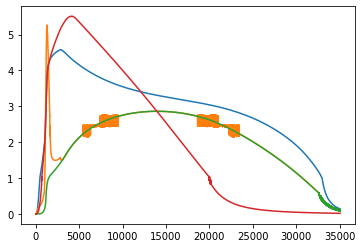

In [6]:
plt.plot(env.data_log["flow"]["O1"])
plt.plot(env.data_log["flow"]["O2"])
plt.plot(env.data_log["flow"]["O3"])
plt.plot(env.data_log["flow"]["O4"])

# Uncontrolled response

In [7]:
env_uc = pystorms.scenarios.gamma()
done = False
while not done:
    done = env_uc.step()

# Bayes Control

In [10]:
import os
import argparse
import numpy as np
import pandas as pd
from pystorms.scenarios import gamma
from GPyOpt.methods import BayesianOptimization


# Gamma Scenario for the basins in series
def GammaData(actions, CTRL_ASSETS=4):

    # Initialize the scenario
    env = gamma()
    done = False

    # Modify the logger function to store depths
    env.data_log["depthN"] = {}
    for i in np.linspace(1, CTRL_ASSETS, CTRL_ASSETS, dtype=int):
        env.data_log["depthN"][str(i)] = []

    # Dont log the params from upstream, we donot care about them
    for i in np.linspace(CTRL_ASSETS + 1, 11, 11 - CTRL_ASSETS, dtype=int):
        del env.data_log["flow"]['O' + str(i)]
        del env.data_log["flooding"][str(i)]

    # Simulate controlled response
    while not done:
        done = env.step(actions)

    # Return the logged params
    return env.data_log


# Objective Function
def f_loss(x):
    # GypOpt uses 2d array
    # pystorms requies 1d array
    x = x.flatten()

    # Simulate the response of control actions
    data = GammaData(x)

    # Convert to pandas dataframes
    depths = pd.DataFrame.from_dict(data["depthN"])
    flows = pd.DataFrame.from_dict(data["flow"])
    flooding = pd.DataFrame.from_dict(data["flooding"])

    # Compute loss - check the performance metric equation in Readme
    loss = 0.0

    # Flooding loss
    for node in flooding.keys():
        if flooding[node].sum() > 0.0:
            loss += 10 ** 4 * flooding[node].sum()

    # Flow deviation
    flows = flows.sub(4.0)
    flows[flows < 0.0] = 0.0
    loss += flows.sum().sum()

    # Prevent basins from storing water at the end.
    for i in depths.values[-1]:
        if i > 0.1:
            loss += i * 10 ** 3

    return loss

# Set the random seed
np.random.seed(42)

# Set path to save model runs
save_path = "./" + str(42) + "_" + str(200) + "_GeneralizabilityGamma4"
os.mkdir(save_path)


# Create the domain
domain = []
for i in range(1, 5):
    domain.append({"name": "var_" + str(i), "type": "continuous", "domain": (0.0, 1.0)})


myBopt = BayesianOptimization(
    f=f_loss, domain=domain,
    model_type="GP",
    acquisition_type="EI",
)

myBopt.run_optimization(
    save_path,
    report_file=save_path + "_report.txt",
    max_iter=200,
    save_inter_models=True,
    intervals=25,
    verbosity=True,
    eps=0.005,
)

num acquisition: 1, time elapsed: 6.42s
num acquisition: 2, time elapsed: 9.58s
num acquisition: 3, time elapsed: 12.83s
num acquisition: 4, time elapsed: 16.26s
num acquisition: 5, time elapsed: 23.81s
num acquisition: 6, time elapsed: 29.86s
num acquisition: 7, time elapsed: 37.41s
num acquisition: 8, time elapsed: 40.99s
num acquisition: 9, time elapsed: 44.35s
num acquisition: 10, time elapsed: 50.46s
num acquisition: 11, time elapsed: 53.72s
num acquisition: 12, time elapsed: 57.05s
num acquisition: 13, time elapsed: 63.76s
num acquisition: 14, time elapsed: 67.14s
num acquisition: 15, time elapsed: 70.46s
num acquisition: 16, time elapsed: 73.80s
num acquisition: 17, time elapsed: 80.17s
num acquisition: 18, time elapsed: 83.41s
num acquisition: 19, time elapsed: 86.70s
num acquisition: 20, time elapsed: 90.06s
num acquisition: 21, time elapsed: 98.05s
num acquisition: 22, time elapsed: 104.12s
num acquisition: 23, time elapsed: 107.40s
num acquisition: 24, time elapsed: 110.79s


{'25': './42_200_GeneralizabilityGamma4/Bayopt25',
 '50': './42_200_GeneralizabilityGamma4/Bayopt50',
 '75': './42_200_GeneralizabilityGamma4/Bayopt75',
 '100': './42_200_GeneralizabilityGamma4/Bayopt100',
 '125': './42_200_GeneralizabilityGamma4/Bayopt125',
 '150': './42_200_GeneralizabilityGamma4/Bayopt150',
 '175': './42_200_GeneralizabilityGamma4/Bayopt175',
 '200': './42_200_GeneralizabilityGamma4/Bayopt200'}

In [11]:
myBopt.x_opt

array([0.34895609, 1.        , 0.21987084, 0.20640974])

In [12]:
env = pystorms.scenarios.gamma()
done = False
while not done:
    done = env.step(myBopt.x_opt)

In [13]:
env.performance()

402895865.4322442

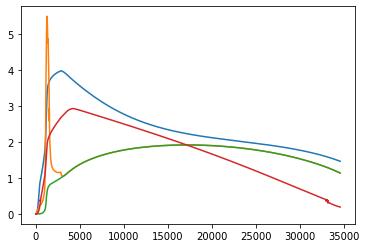

In [16]:
plt.plot(env.data_log["flow"]["O1"])
plt.plot(env.data_log["flow"]["O2"])
plt.plot(env.data_log["flow"]["O3"])
plt.plot(env.data_log["flow"]["O4"])